# Example 3: Clustering spectrograms

* Attempt a rough clustering of calls using sklearn, umap, hdbscan

In [1]:
import sys
sys.path.append("../code/soundsep")

In [2]:
import time

import hdbscan
import numpy as np
import matplotlib.pyplot as plt
import umap
from IPython.display import clear_output, Audio, display
from sklearn.decomposition import PCA
from soundsig.sound import plot_spectrogram

from interfaces.audio import LazyWavInterface
from plotting_utils import MultiChannelPlotter, MultiSpecPlotter

%load_ext autoreload
%autoreload 2

In [3]:
all_call_spectrograms = np.load("example_spectrograms.npy")[()]

In [4]:
all_calls = np.load("example_calls.npy")[()]

In [5]:
audio_signal = LazyWavInterface("example.wav", dtype=np.float64)

## 2. Try to find a good space to visualize/cluster in

My current attempt is just PCA first, then using umap to try to get it clumpy, and then assigning clusters with hdbscan. As you will see, this is pretty rough and not ideal.

In [6]:
X = all_call_spectrograms.reshape(len(all_call_spectrograms), -1)

### Projection using UMAP

First use PCA as dimesionality reduction, and then fit a umap embedding.

It is worth tweaking the parameters to adjust how clumpy the embedding is, and `fit_every_nth_point` to adjust how much of the data is used to compute the embedding.

* `n_neighbors`: smaller is more local, larger incorporates more global structure

* `min_dist`: how close points are allowed to be in the final embedding. Higher values of min_dist mean that points must be spread further apart

In [7]:
X_pca = PCA(n_components=20).fit_transform(X)

In [8]:
fit_every_nth_point = 2
trans = umap.UMAP(n_neighbors=10, repulsion_strength=100.0, min_dist=0.9).fit(X_pca[::fit_every_nth_point])
X_umap = trans.transform(X_pca)

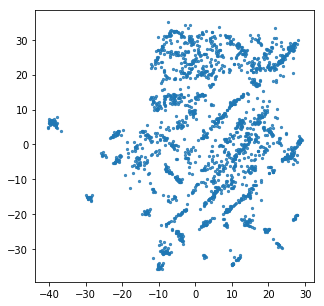

In [9]:
fig = plt.figure(figsize=(5, 5))
plt.scatter(*X_umap.T, alpha=0.8, s=5)
plt.show()
plt.close(fig)

## 3. Label points using above embedding

HDBSCAN is a density based clustering algorithm that doesn't require you to define how many clusters exist beforehand. In this situation, this will likely undercluster the data. But its a first step. 

In [10]:
labels = hdbscan.HDBSCAN().fit_predict(X_umap)

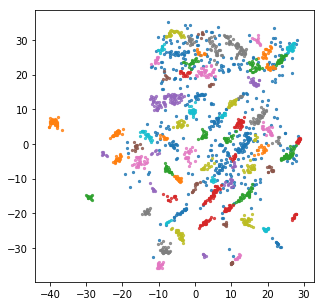

In [11]:
fig = plt.figure(figsize=(5, 5))
for l in np.unique(labels):
    plt.scatter(*X_umap[labels == l].T, alpha=0.8, s=5)
plt.show()
plt.close(fig)


## 4. Visualize 5 of the clusters

The cluster labeled "-1" is the cluster of spectrograms that did not make it into a proper cluster. It is clear that there are many calls that failed to get grouped up.

'Label -1 (n=338)'

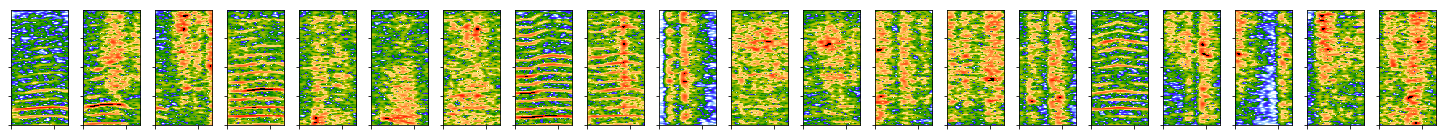

'Label 0 (n=34)'

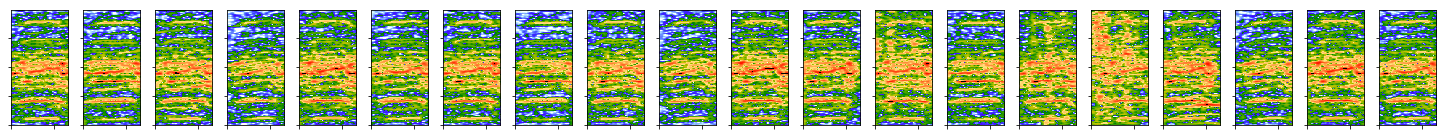

'Label 1 (n=15)'

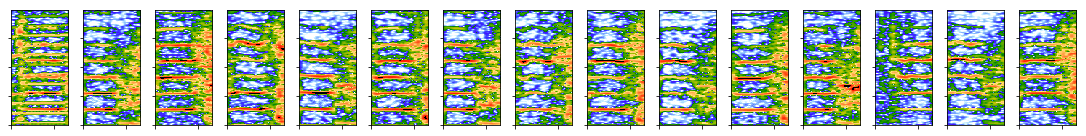

'Label 2 (n=11)'

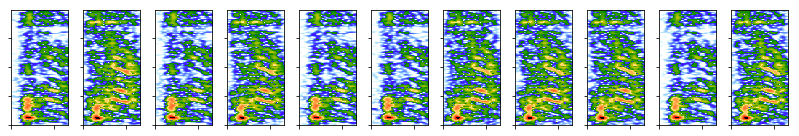

'Label 3 (n=6)'

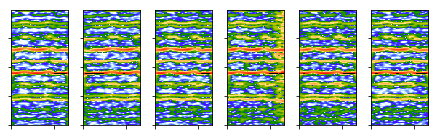

In [12]:
for l in np.unique(labels)[:5]:
    display("Label {} (n={})".format(l, int(np.sum(labels == l))))
    specs = all_call_spectrograms[labels == l][:20]
    data = [
        (
            np.arange(0, spec.shape[1]),
            np.arange(0, spec.shape[2]),
            spec[0]
        ) for spec in specs
    ]
    plotter = MultiSpecPlotter(data, panel_size=(1, 2), layout="horizontal", colorbar=False)
    plotter.plot()
    
    silence = np.zeros(shape=(int(audio_signal.sampling_rate) // 2,))
    sig = np.zeros(shape=(0,))
    for idx in range(10):
        if idx >= np.sum(labels == l):
            break
        sig = np.concatenate([sig, all_calls[labels == l][idx][:, 0], silence])
    
    display(Audio(sig, rate=audio_signal.sampling_rate, normalize=False))

## 5. Visualize all cluster means

In [13]:
cluster_means = []
cluster_labels = []
for l in np.unique(labels):
    # Don't include the -1 cluster which is just all the points that didn't make it into a cluster
    if l == -1:
        continue
    specs = all_call_spectrograms[labels == l]
    cluster_means.append(np.mean(specs, axis=0))
    cluster_labels.append(l)
cluster_means = np.array(cluster_means)
cluster_labels = np.array(cluster_labels)

These are the cluster means


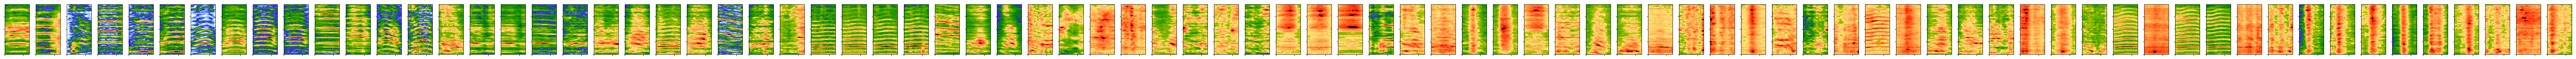

In [14]:
data_ch0 = [
    (
        np.arange(0, spec.shape[1]),
        np.arange(0, spec.shape[2]),
        spec[0]
    ) for spec in cluster_means
]
print("These are the cluster means")
plotter = MultiSpecPlotter(data_ch0, panel_size=(1, 2), layout="horizontal", colorbar=False)
plotter.plot()

These are the relative amplitudes on the two channels for the cluster means


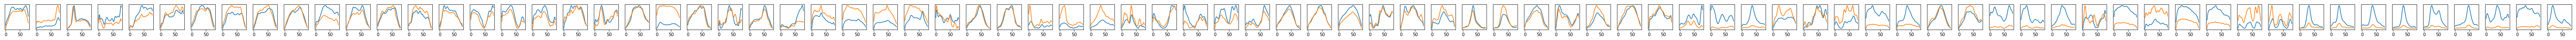

In [15]:
data_amp_env = [
    np.mean(spec, axis=1) for spec in cluster_means
]
print("These are the relative amplitudes on the two channels for the cluster means")
plotter = MultiChannelPlotter(data_amp_env, panel_size=(1, 1), layout="horizontal")
plotter.set_plot_fn(lambda x, ax: ax.plot(x.T))
plotter.map_axes(lambda ax: ax.set_yticks([]))
fig = plotter.plot()

## 7. Export embedding and labels

It is clear that the automatic sorting leaves a lot to be desired. Until that can be fixed, you need to manually sort data.

I would like at some point like to make a GUI that visualizes the calls in the umap embedding and see data at a glance, allows you to select clusters, label and remove cage noise, and reassign labels.

In [16]:
np.save("example_embedding.npy", X_umap)
np.save("example_hdbscan_labels.npy", labels)